In [ ]:
# load model 
import pickle
import torch as tc
from transformer_lens import HookedTransformer

timestamp = '20240429143845'
with open(f'saved_models/{timestamp}.cfg', 'rb') as f:
    cfg = pickle.load(f)
# load model
model = HookedTransformer(cfg)
model.load_state_dict(tc.load(f'saved_models/{timestamp}.pt'))

<All keys matched successfully>

In [ ]:
cfg

HookedTransformerConfig:
{'act_fn': 'relu',
 'attention_dir': 'bidirectional',
 'attn_only': False,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 9,
 'd_mlp': 35,
 'd_model': 34,
 'd_vocab': 7,
 'd_vocab_out': 5,
 'default_prepend_bos': True,
 'device': 'cpu',
 'dtype': torch.float32,
 'eps': 1e-05,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': True,
 'initializer_range': 0.13719886811400708,
 'model_name': 'custom',
 'n_ctx': 8,
 'n_devices': 1,
 'n_heads': 1,
 'n_key_value_heads': None,
 'n_layers': 3,
 'n_params': 10812,
 'normalization_type': None,
 'original_architecture': None,
 'parallel_attn_mlp': False,
 'positional_embedding_type': 'standard',
 'post_embedding_ln': False,
 'rotary_adjacent_pairs': False,
 'rotary_base': 10000,
 'rotary_dim': None,
 'scale_attn_by_inverse_layer_idx': False,
 'seed': None,
 'tokenizer_name': None,
 'tokenizer_pre

In [ ]:
import itertools
vocab_size = cfg.d_vocab_out
input_size = cfg.d_vocab
def get_all_sequences(max_seq_len, vocab_size):
    # Generate all possible sequences of length n with vocabulary size m
    sequences = itertools.product(range(vocab_size), repeat=max_seq_len)
    sequences = [tc.tensor(seq) for seq in sequences]
    return sequences
sequences = get_all_sequences(input_size, vocab_size)
print(f'Generated {len(sequences)} sequences of length {input_size} with vocabulary size {vocab_size}')

Generated 78125 sequences of length 7 with vocabulary size 5


In [ ]:
# sequences is a list, but we need a tensor
sequences = tc.stack(sequences)
print(sequences.shape)

original_logits, cache = model.run_with_cache(sequences)
print(original_logits.numel())

torch.Size([78125, 7])
2734375


In [ ]:
import plotly.express as px
import transformer_lens.utils as tl_utils


# def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
#     px.imshow(tl_utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

# imshow()
from matplotlib import pyplot as plt
import numpy as np

def imshow(tensor, xaxis="", yaxis="", **kwargs):
    plt.imshow(tensor.detach().numpy(), cmap='RdBu', **kwargs)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.show()

In [ ]:
for param_name, param in cache.items():
    print(param_name, param.shape)


hook_embed torch.Size([78125, 7, 34])
hook_pos_embed torch.Size([78125, 7, 34])
blocks.0.hook_resid_pre torch.Size([78125, 7, 34])
blocks.0.attn.hook_q torch.Size([78125, 7, 1, 9])
blocks.0.attn.hook_k torch.Size([78125, 7, 1, 9])
blocks.0.attn.hook_v torch.Size([78125, 7, 1, 9])
blocks.0.attn.hook_attn_scores torch.Size([78125, 1, 7, 7])
blocks.0.attn.hook_pattern torch.Size([78125, 1, 7, 7])
blocks.0.attn.hook_z torch.Size([78125, 7, 1, 9])
blocks.0.hook_attn_out torch.Size([78125, 7, 34])
blocks.0.hook_resid_mid torch.Size([78125, 7, 34])
blocks.0.mlp.hook_pre torch.Size([78125, 7, 35])
blocks.0.mlp.hook_post torch.Size([78125, 7, 35])
blocks.0.hook_mlp_out torch.Size([78125, 7, 34])
blocks.0.hook_resid_post torch.Size([78125, 7, 34])
blocks.1.hook_resid_pre torch.Size([78125, 7, 34])
blocks.1.attn.hook_q torch.Size([78125, 7, 1, 9])
blocks.1.attn.hook_k torch.Size([78125, 7, 1, 9])
blocks.1.attn.hook_v torch.Size([78125, 7, 1, 9])
blocks.1.attn.hook_attn_scores torch.Size([78125, 1

In [ ]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'blocks.2.attn.hook_q', 'blocks.2.attn.hook_k', 'blocks.2.attn.hook_v', 'blocks.2.attn.hook_attn_scores', 'blocks.2.attn.hook_pattern', 'blocks.2.attn.hook_z', 'blocks.2.hook_attn_out', 'blocks.2.hook_resid_mid', 'blocks.2.mlp

In [ ]:
pattern_a = cache["pattern", 0, "attn"][:, :, -1, 0]
pattern_b = cache["pattern", 0, "attn"][:, :, -1, 1]
neuron_acts = cache["post", 0, "mlp"][:, -1, :]
neuron_pre_acts = cache["pre", 0, "mlp"][:, -1, :]



In [ ]:
pattern_a.shape, pattern_b.shape, neuron_acts.shape, neuron_pre_acts.shape


(torch.Size([78125, 1]),
 torch.Size([78125, 1]),
 torch.Size([78125, 35]),
 torch.Size([78125, 35]))

In [ ]:
p = cache["pattern", 0].mean(dim=0)[0]

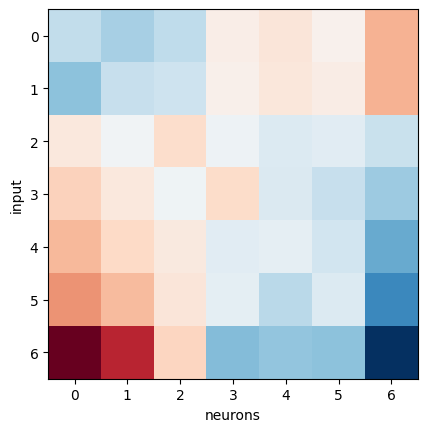

In [ ]:


imshow(p, xaxis="neurons", yaxis="input")

In [ ]:
cache["post", 0, "mlp"].shape

torch.Size([78125, 7, 35])

In [ ]:
sequences[21010]

tensor([1, 1, 3, 3, 0, 2, 0])

In [ ]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'blocks.2.attn.hook_q', 'blocks.2.attn.hook_k', 'blocks.2.attn.hook_v', 'blocks.2.attn.hook_attn_scores', 'blocks.2.attn.hook_pattern', 'blocks.2.attn.hook_z', 'blocks.2.hook_attn_out', 'blocks.2.hook_resid_mid', 'blocks.2.mlp

tensor([0, 1, 2, 3, 4, 4, 3])


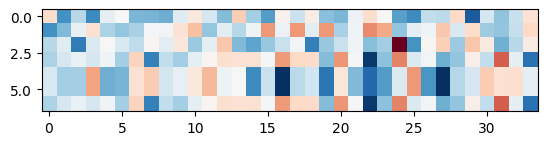

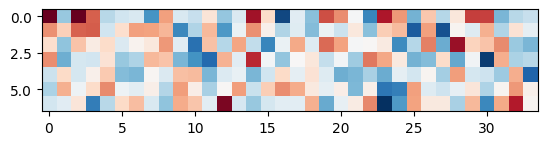

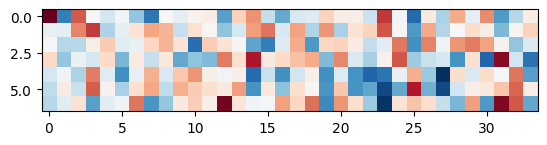

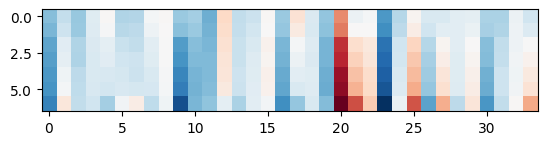

In [ ]:
i = 4873
print(sequences[i])
imshow(cache["hook_embed"][i])
imshow(cache["hook_pos_embed"][i])
# imshow(cache["hook_embed"][i] + cache["hook_pos_embed"][i])
imshow(cache["blocks.0.hook_resid_pre"][i]) # = embed + pos_embed
imshow(cache["blocks.0.hook_attn_out"][i])

In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

print(len(sequences))
print(cache["hook_embed"].shape)
print(cache["hook_pos_embed"].shape)
print(cache["blocks.0.hook_resid_pre"].shape)
print(cache["blocks.0.hook_attn_out"].shape)
# Create a slider to control the value of i
slider = widgets.IntSlider(min=0, max=len(sequences)-1, value=4873, description='i:')
display(slider)

# Function to update the outputs based on the value of i
def update_outputs(i):
    print(sequences[i])
    plt.figure(figsize=(10, 10))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cache["hook_embed"][i])
    plt.title("hook_embed")
    
    plt.subplot(2, 2, 2)
    plt.imshow(cache["hook_pos_embed"][i])
    plt.title("hook_pos_embed")
    
    plt.subplot(2, 2, 3)
    plt.imshow(cache["blocks.0.hook_resid_pre"][i])
    plt.title("blocks.0.hook_resid_pre")
    
    plt.subplot(2, 2, 4)
    plt.imshow(cache["blocks.0.hook_attn_out"][i])
    plt.title("blocks.0.hook_attn_out")
    
    plt.tight_layout()
    plt.show()

# Connect the slider to the update_outputs function
slider.observe(lambda change: update_outputs(change.new), names='value')

IntSlider(value=4873, description='i:', max=78124)

In [ ]:
i = 0
sequences[i]

tensor([0, 0, 0, 0, 0, 0, 0])

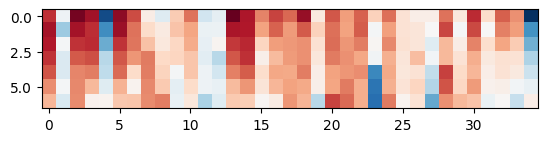

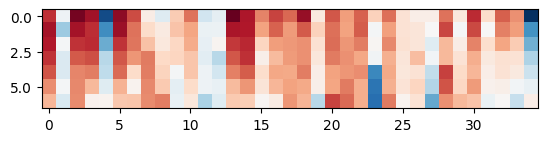

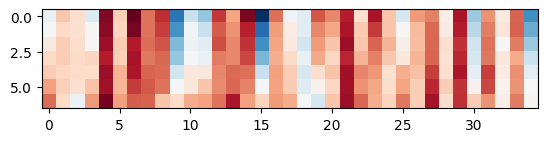

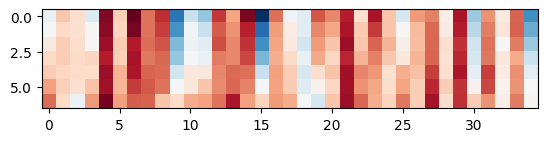

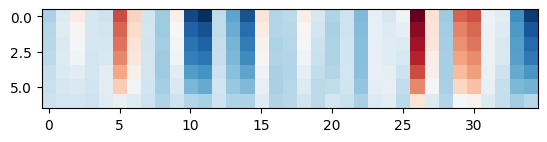

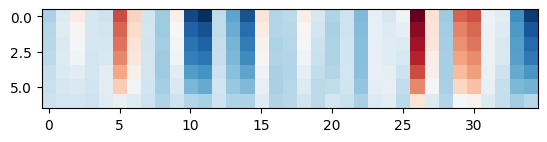

In [ ]:
imshow(cache["pre", 0, "attn"][i])

imshow(cache["pre", 0, "mlp"][i])

imshow(cache["pre", 1, "attn"][i])

imshow(cache["pre", 1, "mlp"][i])
imshow(cache["pre", 2, "attn"][i])

imshow(cache["pre", 2, "mlp"][i])

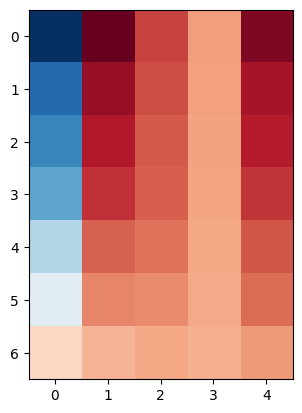

In [ ]:
imshow(original_logits[i])

In [ ]:

original_logits[i].shape

torch.Size([7, 5])

In [ ]:
sequences.shape

torch.Size([78125, 7])